![Header](https://raw.githubusercontent.com/tahir-za/demo/master/Header2.jpg)

# Using NLP To Classify Personality Types 
## MBTI personality profile prediction
**Classification Team 2: Jessica Ferguson, Tahir Hargey, Jacob Khoza, Oarabile Mokgalagadi, Tiyani Myakayakat**

<a id='Index'></a>
# Index

#### 1. [Introduction](#sec1)
#### 2. [Importing Libraries and Data](#sec2)
#### 3. [EDA](#sec3)
#### 4. [Preprocessing](#sec4)
#### 5. [Feature Engineering](#sec5)
#### 6. [Modelling](#sec6)
#### 7. [Model evaluation](#sec7)
#### 8. [CSV output for Kaggle](#sec8)
#### 9. [Conclusion](#sec9)

<a id="sec1"></a>
## 1. Introduction

This model predicts an individual’s personality profile based on the *Myers-Briggs Type Indicator®* personality inventory, using forum posts as input data.

There are 16 personality types made up of 4 personality aspects:

- **Mind:** shows how we interact with our surroundings
- **Energy:** determines how we see the world and process information
- **Nature:** determines how we make decisions and cope with emotions
- **Tactics:** reflects our approach to work, planning and decision-making

Each personality aspect is further made up of a spectrum between 2 personality traits, each represented by a letter:

- Mind: Introverted (I) or Extraverted (E)
- Energy: Sensing (S) or Intuitive (N)
- Nature: Feeling (F) or Thinking (T)
- Tactics: Perceiving (P) or Judging (J)

The letters are combined to give the personality type, for example ISTP.

Source: https://www.16personalities.com/articles/our-theory

<a id="sec2"></a>
## 2. Import Libraries and data

In [1]:
#import the initial libraries
import numpy as np
import pandas as pd

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#text processing
import string
import nltk
import spacy

#text visualisation
from wordcloud import WordCloud

#initializing defaults
sns.set()
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

Import the train and test csv's as train_df and test_df.

In [3]:
# Train data
train_df = pd.read_csv('../input/mbti-classification/train.csv')
# Test Data
test_df = pd.read_csv('../input/mbti-classification/test.csv')

[Back to Index](#Index)

<a id="sec3"></a>


<a id="sec3"></a>
# 3. EDA
### Exploratory Data Analysis

Let's look at the intial datasets.

In [4]:
train_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
test_df.head()

,id,posts
0,1,Musical Linguistic Logic & Naturalist (tied)|...
1,2,'You: hello :) Stranger: hii You: how are you ...
2,3,'What worked for me was knowing that limerence...
3,4,'Please forget about him. You should definitel...
4,5,"'Ooh, ENTJ Celestia is actually an interesting..."


Multiple posts appear to be combined for each indivual so we need to first separate the posts. 

Then we will compare each personality type against each other and see if there is any apparent evidence to support their classification.

In [6]:
train_df['num posts'] = train_df['posts'].apply(lambda x:len(x.split('|||')))
test_df['num posts'] = test_df['posts'].apply(lambda x:len(x.split('|||')))
train_df.tail()

,type,posts,num posts
6501,INFP,very funny....i always appreciate good sense o...,50
6502,INTJ,'Pregnant. I've never liked hearing the word. ...,50
6503,INFP,'IT DOESN'T LET ME GO TO SLEEP HAHA http://ww...,50
6504,INFP,'Thanks v much @ heroindisguise for your elab...,49
6505,INFP,'Me: INFP Platonic Soulmate: ISTJ Thing 1: ES...,50


Let's create a column with the number of words per post.

In [7]:
train_df['words per post'] = train_df['posts'].apply(lambda x:len(x.split()))/ train_df['num posts']
test_df['words per post'] = test_df['posts'].apply(lambda x:len(x.split()))/ test_df['num posts']
train_df.head()

,type,posts,num posts,words per post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,50,11.12
1,ENTP,'I'm finding the lack of me in these posts ver...,50,23.40
2,INTP,'Good one _____ https://www.youtube.com/wat...,50,16.72
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",50,21.28
4,ENTJ,'You're fired.|||That's another silly misconce...,50,19.34


Now let's look at the number of URL's per post.

In [8]:
train_df['num urls'] = train_df['posts'].apply(lambda x:x.count('htt'))
test_df['num urls'] = test_df['posts'].apply(lambda x:x.count('htt'))
train_df.head()

,type,posts,num posts,words per post,num urls
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,50,11.12,24
1,ENTP,'I'm finding the lack of me in these posts ver...,50,23.40,10
2,INTP,'Good one _____ https://www.youtube.com/wat...,50,16.72,5
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",50,21.28,2
4,ENTJ,'You're fired.|||That's another silly misconce...,50,19.34,6


Our last column will be to determine the post length variance.

In [9]:
train_df['words variance post'] = train_df['posts'].apply(lambda x:np.var([len(post) for post in x.split('|||')]))/ train_df['num posts']
test_df['words variance post'] = test_df['posts'].apply(lambda x:np.var([len(post) for post in x.split('|||')]))/ test_df['num posts']
train_df.head()

,type,posts,num posts,words per post,num urls,words variance post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,50,11.12,24,63.742600
1,ENTP,'I'm finding the lack of me in these posts ver...,50,23.40,10,80.093312
2,INTP,'Good one _____ https://www.youtube.com/wat...,50,16.72,5,105.083008
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",50,21.28,2,101.672992
4,ENTJ,'You're fired.|||That's another silly misconce...,50,19.34,6,106.303232


Let us now visualise these columns by personality type.

First lets look at the sum of each of these columns by personality type.

Text(0.5, 0, 'Personality Type')

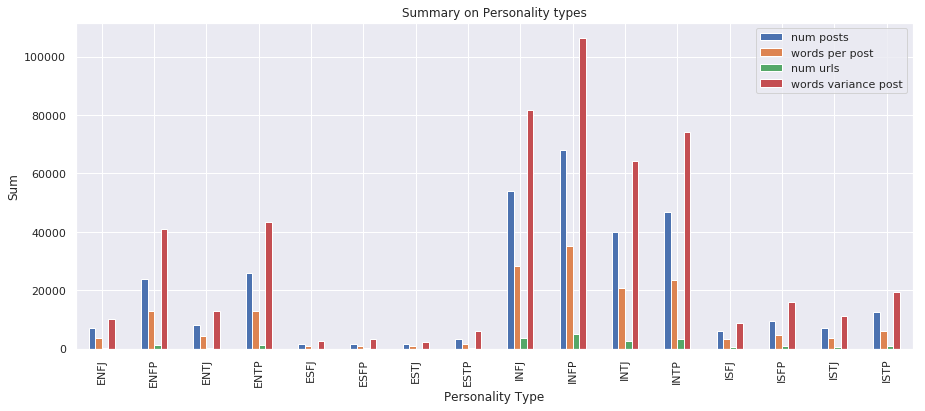

In [10]:
figSize = (15,6)
train_df.groupby('type').sum().plot.bar(figsize=figSize)
plt.title('Summary on Personality types')
plt.ylabel('Sum')
plt.xlabel('Personality Type')

From this graph it is clear that the highest number of posts are from the more introverted, less outgoing group of people, and the converse is also true.  We noted that the highest number of posts is by INFP which is also the personality type that is considered to be the most introverted of the 16 types. The lowest number of posts is by ESTJ which is considered to be the most extroverted personality type. <br>
Source: https://www.erikthor.com/extroversion-introversion/

Next let's look at the average of each of these columns by personality type.

Text(0.5, 0, 'Personality Type')

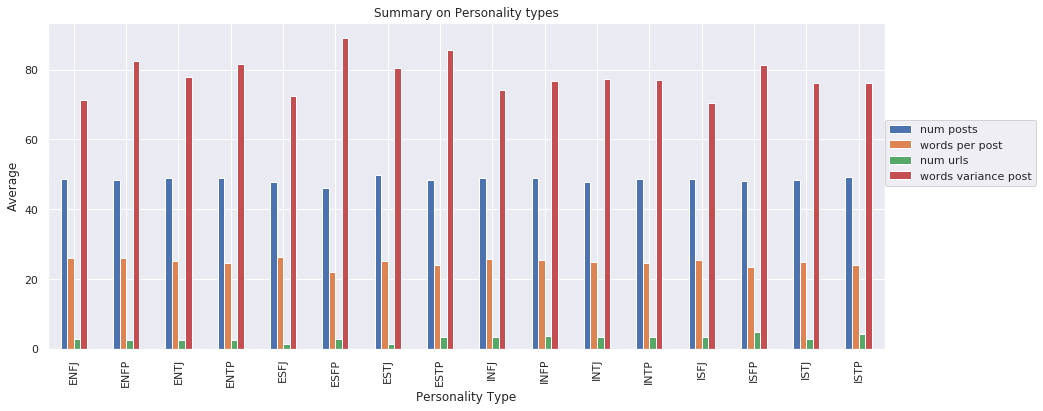

In [11]:
train_df.groupby('type').mean().plot.bar(figsize=figSize)
plt.legend(loc=(1,0.5))
plt.title('Summary on Personality types')
plt.ylabel('Average')
plt.xlabel('Personality Type')

We can see from the above graph that the averages for each personality type are similar.

Lets us look at the variance of each personality type.

Text(0.5, 0, 'Personality Type')

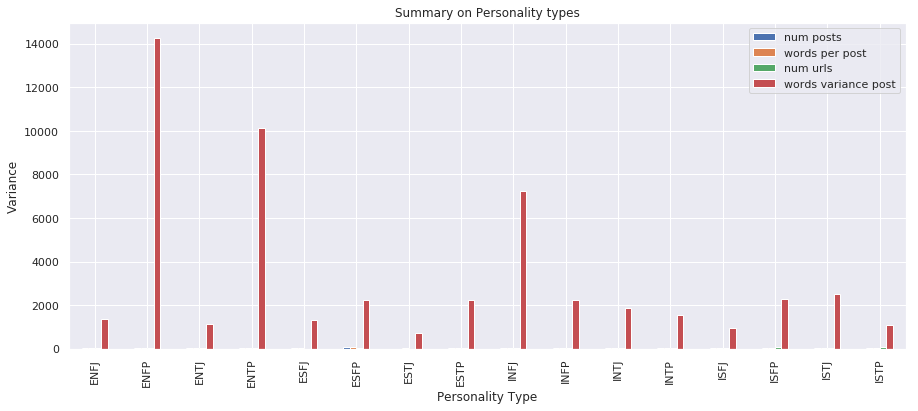

In [12]:
train_df.groupby('type').var().plot.bar(figsize=figSize)
plt.title('Summary on Personality types')
plt.ylabel('Variance')
plt.xlabel('Personality Type')

The variance graph shows us that the personality type with the most word variance per post is ENFP.

Using .describe we can have a quick glance at the count, max, min etc. of the data.

In [13]:
train_df.describe()

,num posts,words per post,num urls,words variance post
count,6506.000000,6506.000000,6506.000000,6506.000000
mean,48.654780,25.108721,3.276514,77.372397
std,5.698101,5.832345,5.803780,66.216448
min,1.000000,0.420000,0.000000,0.000000
25%,50.000000,21.620000,0.000000,56.534184
50%,50.000000,25.980000,1.000000,76.187540
75%,50.000000,29.440000,4.000000,92.153766
max,83.000000,38.000000,91.000000,2664.500000


In [14]:
test_df.describe()

,id,num posts,words per post,num urls,words variance post
count,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000
mean,1085.000000,48.808207,25.267589,3.399723,81.018428
std,626.280688,5.620133,5.641971,5.770137,125.345542
min,1.000000,2.000000,4.220000,0.000000,0.109992
25%,543.000000,50.000000,22.100000,0.000000,55.364000
50%,1085.000000,50.000000,26.080000,1.000000,75.327592
75%,1627.000000,50.000000,29.540000,4.000000,91.124648
max,2169.000000,89.000000,36.980000,73.000000,2738.000000


It would also be useful to have a look at the number of posts per personality type.

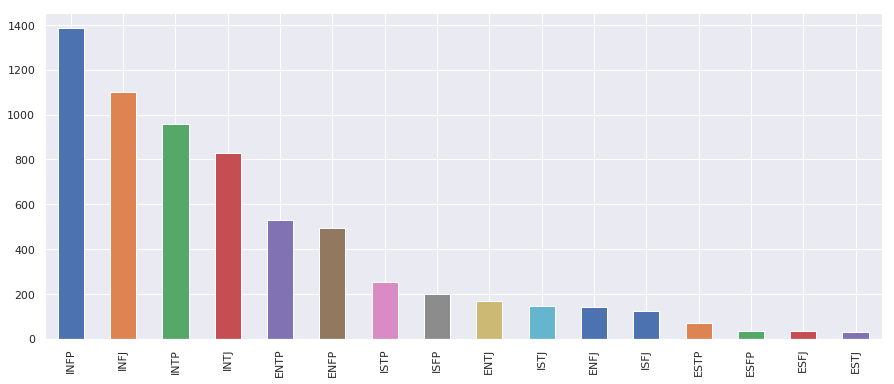

In [15]:
train_df.type.value_counts().plot.bar(figsize=figSize)

In [16]:
train_df.type.value_counts()

INFP    1386
INFJ    1100
INTP     960
INTJ     830
ENTP     530
ENFP     496
ISTP     255
ISFP     198
ENTJ     167
ISTJ     145
ENFJ     143
ISFJ     124
ESTP      71
ESFP      36
ESFJ      35
ESTJ      30
Name: type, dtype: int64

Here we can cleary see the disparity between the types of personalities and class imbalance.

### Class Imbalance

We can now look at the data imbalances between the personality aspects by plotting the values.
To do this we will first create columns for each of the four aspects.

In [17]:
#Create columns for Mind, Energy, Nature and Tactics
train_df['Mind'] = train_df.type.apply(lambda x:x[0] == 'E')
train_df['Energy'] = train_df.type.apply(lambda x:x[1] == 'N')
train_df['Nature'] = train_df.type.apply(lambda x:x[2] == 'T')
train_df['Tactics'] = train_df.type.apply(lambda x:x[3] == 'J')

In [18]:
#Define a list of columns to train
cols_to_train = ['Mind', 'Energy', 'Nature', 'Tactics']

Text(0.5, 1.0, 'Mind')

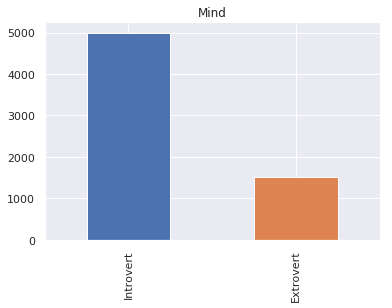

In [19]:
#Plot the values
train_df[cols_to_train[0]].apply(lambda x: 'Extrovert' if x else 'Introvert').value_counts().plot.bar()
plt.title(cols_to_train[0])

There is a clear imbalance in the 'Mind' variable between 'Introverted' and 'Extroverted'.

Text(0.5, 1.0, 'Energy')

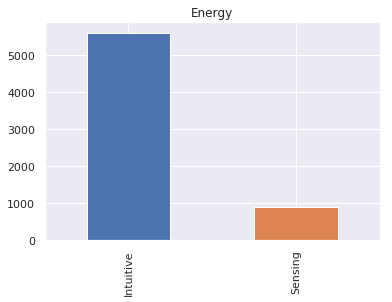

In [20]:
train_df[cols_to_train[1]].apply(lambda x: 'Intuitive' if x else 'Sensing').value_counts().plot.bar()
plt.title(cols_to_train[1])

Once again there is an imbalance in the 'Energy' variable between 'Intuitive' and 'Sensing' personality traits.

Text(0.5, 1.0, 'Nature')

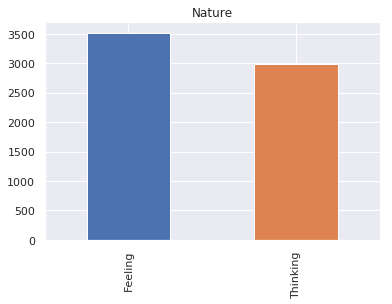

In [21]:
train_df[cols_to_train[2]].apply(lambda x: 'Thinking' if x else 'Feeling').value_counts().plot.bar()
plt.title(cols_to_train[2])

With the 'Nature' variable, the data is much more balanced between 'Feeling' and 'Thinking'.

Text(0.5, 1.0, 'Tactics')

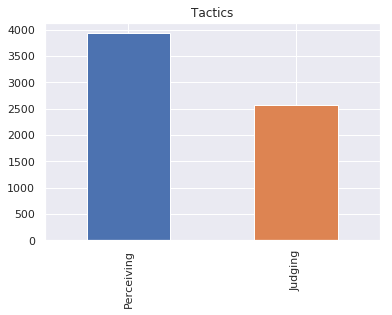

In [22]:
train_df[cols_to_train[3]].apply(lambda x: 'Judging' if x else 'Perceiving').value_counts().plot.bar()
plt.title(cols_to_train[3])

The data is slightly imbalanced in the 'Tactics' variable between 'Perceiving' and 'Judging'.

Data imbalance affects our ability to predict accurately and should be addressed before fitting our predictive model. Models such as Logistic Regression perform poorly with imbalanced data.

### Common words
Let us investigate the most common words used by each personality type on their posts as these could be used in our model to predict the personality type.

In [23]:
# A function to create word clouds
def visualize(label):
    '''This function creates a word cloud for each personality type to visualise the most common words'''
    words = ''
    for msg in train_df[train_df['type'] == label]['posts']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600,height=400).generate(words)
    return wordcloud

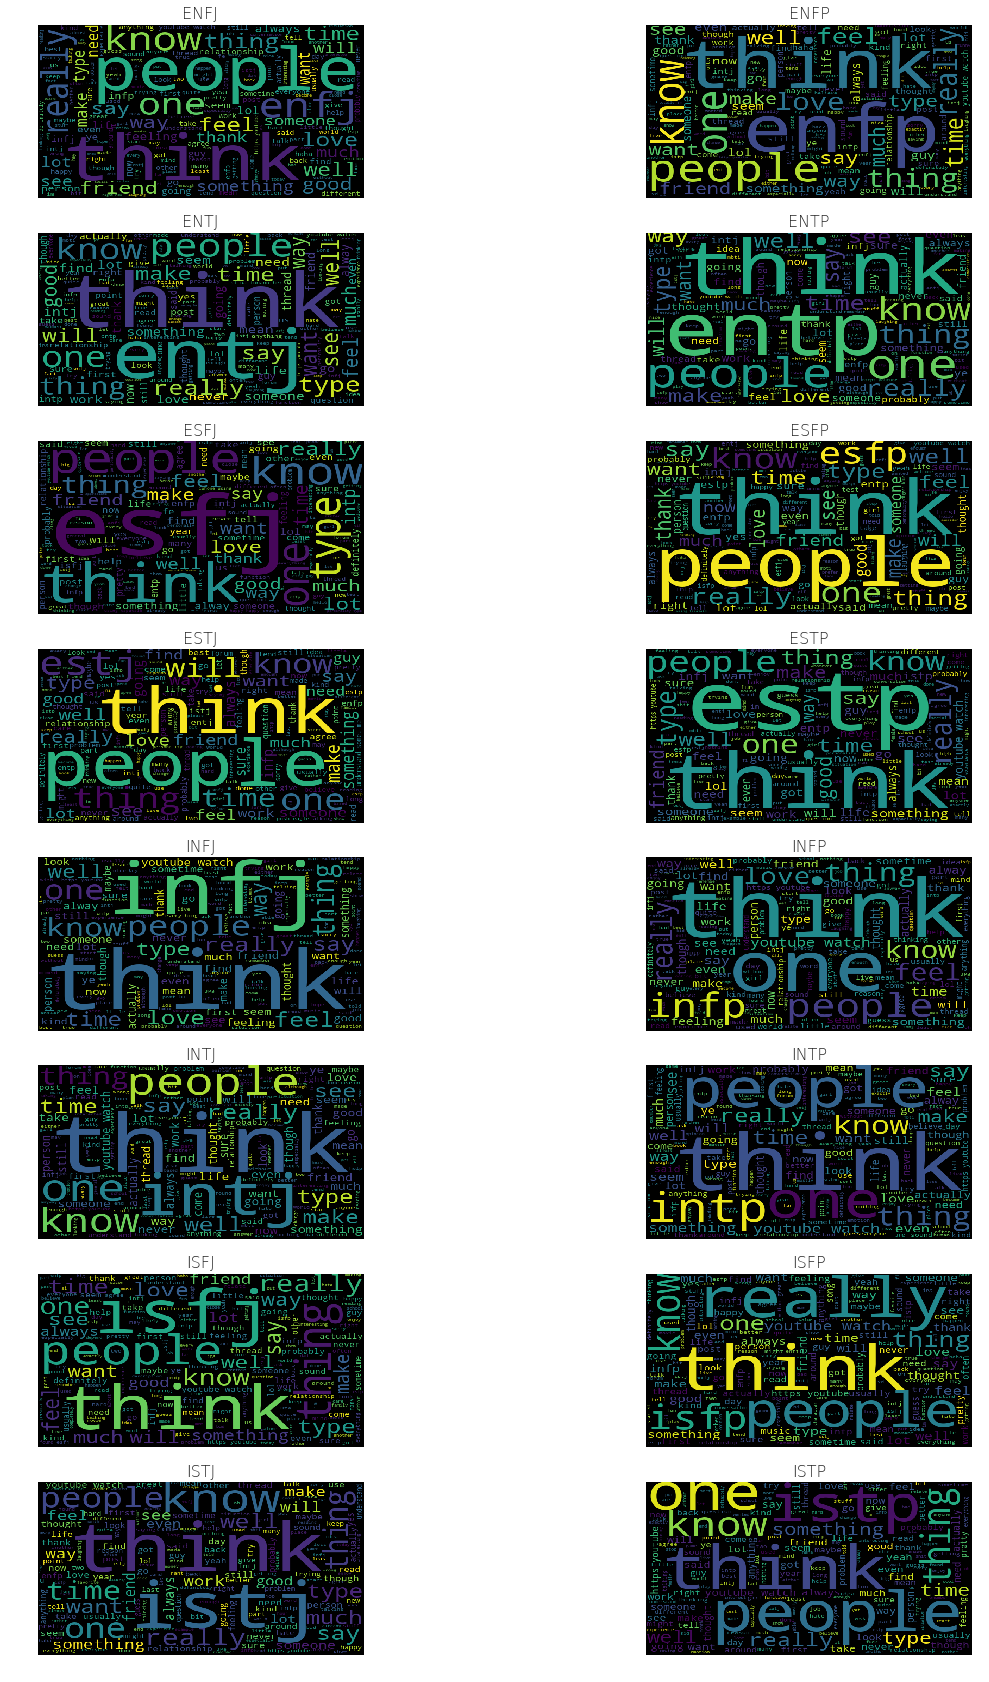

In [24]:
# Displaying the Wordcloud for each personality type
types = sorted(train_df.type.unique())
fig = plt.figure(figsize=(20,30))
i = 0
for type in types:
    ax = fig.add_subplot(8,2,i+1)
    i += 1
    wordcloud = visualize(type)
    ax.imshow(wordcloud, aspect=0.8)
    ax.set_title(type, {'fontsize': 16,'fontweight' : 3})
    ax.axis('off')

From the word clouds we can see the most commonly used words by each personality type. We can also see that each personality type seems to mention their type in their posts. Now let's look at the most uncommon words.

In [25]:
def get_most_uncommon_words(type,df):
    """
        This function retrieves the most uncommon words.
        input:  type-label of the personality aspect to predict
                df- dataframe to extract the information from
        
        output: dataframe with the uncommon words from the two personality types
    """
    words = ''
    #get top 30 words for the first class
    for msg in df[df[type] == True]['posts']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(max_words=30).generate(words)
    #get the top 30 words for the second class
    for msg in df[df[type] == False]['posts']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud1 = WordCloud(width=600,height=400,max_words=30).generate(words)
    #get the most uncommon words from the two classes
    s1 = pd.Series(dict(wordcloud.words_))
    s2 = pd.Series(dict(wordcloud1.words_))
    dtf = pd.concat([s1,s2],axis=1)
    #select only the words that appear in one personality type and return the results
    return dtf[np.sum(dtf.isnull(),axis=1) == 1]

##### Uncommon words for Nature

The code to run would be: 
get_most_uncommon_words('Nature',train_df)

This however requires some time for processing, therefore we have only included the results below.

#####  Uncommon words for Tactics

Using the least common words for the different aspects we can easily see which words distinguish the two personality types.

[Back to Index](#Index)

<a id="sec4"></a>
# 4. Pre-Processing

### Sample Post Inspection

Now that we have had an overview of what is happening, let us pick a random post and see how we can reduce it into a more machine learning-friendly format. We will start off by stripping off any links that are included in the post. We will then perform the traditional NLP data preprocessing steps. Due to the size of the document, we will run the commands once and save the results into a file. We will use this file to retrieve our data on subsequent runs.

In [26]:
#let us pick the second user's posts from our list
test_string = train_df.iloc[1][1]

In [27]:
#let us count the total number of words for the user's posts
len(test_string.split())

1170

In [28]:
#let us count the total number of characters for the user's posts
len(test_string)

7053

*We start off with over 7000 characters.*

In [29]:
#let us view the actual collection of posts
test_string

"'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/6020d1f9da

<br>
Now let us create a function to remove links/url's from our test

In [30]:
def remove_links(text):
    '''This function removes links/urls and | from text'''
    #Replacing ... with a space
    text = text.replace("..."," ")
    #Replacing ||| with a space
    text = [" ".join(string.split("|||")) for string in text.split("  ") if not string.rstrip().startswith('http')]
    #Removing links
    text = [t for t in "".join(text).split() if not (t.rstrip().startswith('http') or t.rstrip().startswith("'htt"))]
    return " ".join(text)

In [31]:
#let us remove the links and see how many words we are left with
test_string2 = remove_links(test_string)
print(len(test_string2.split()))
print(len(test_string2))

1190
6243


After removing the links we are down to 6243, that is over 800 less characters.

In [32]:
test_string2

"'I'm finding the lack of me in these posts very alarming. Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough Giving new meaning to 'Game' theory. Hello *ENTP Grin*That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins. This + Lack of Balance and Hand Eye Coordination. Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you I over think things sometimes. I go by the old Sherlock Holmes quote.Perhaps,

#### Creating our very own text preprocessor 

*Pleaese note that you may need to install spacy. If you already have it installed, you may still need to install and link en_core_web_sm*

Run the following command on your terminal to link en_core_web_sm to spacy:
`python -m spacy download en_core_web_sm`

Otherwise, if you do not have spacy already installed. First run the below command on your terminal
`pip install spacy`

In [33]:
#Set our stemmer to PorterStemmer to reduce the words to its root stem
stemmer = nltk.stem.PorterStemmer()
#Setting our NLP model in Spacy
nlp = spacy.load('en_core_web_sm')
#Set the tokenizer
tknzr = nltk.tokenize.TweetTokenizer()
#Create the stopwords object from the Spacy NLP model
stopwords = nlp.Defaults.stop_words

Here we define a function that will perform our text preprocessing. We start off by removing any links that may be in the input text. We follow this by lower casing all characters. We then tokenize our text data and drop common stopwords plus punctuations. This is followed by lemmatizing and stemming respectively. We then remove all non-word text.


Several studies show that extroverts tend to use the word 'I' more often than their introverted counterparts. Since 'I' is a stopword, you may choose to remove it from the list of stopwords. There are several other stopwords which can be retained. However, to build a simple model, we chose to remove all stopwords.

In [34]:
def my_preprocessor(text):
   """
        This function performs text preprocessing.
        input text - string object
        output text - lower case,punctuation free, and non-stopwords containing string object 
   """
   text = remove_links(text)
   text = text.lower()
   tokens = tknzr.tokenize(text)
   tokens = [token for token in tokens if not (token in stopwords or token in string.punctuation)]
   doc = nlp(" ".join(tokens))
   tokens = [token.lemma_ for token in doc if len(token.lemma_) > 2 and not (token.lemma_[0] == '-' and token.lemma_[-1] =='-')]
   tokens = [token.replace("."," ") for token in tokens if not token[0].isnumeric()]
   text = " ".join(tokens)
   return text

In [35]:
#let us see what our text looks like now
test_string3 = (my_preprocessor(test_string))
len(test_string3.split())

487

In [36]:
test_string3

'find lack post alarm sex bore position example girlfriend currently environment creatively use cowgirl missionary not give new meaning game theory hello entp grin that take converse flirting acknowledge presence return word smooth wordplay cheeky grin lack balance hand eye coordination real test score internet test funny score higher now like response thread mention not believe test banish know entp vanish site year half return find people comment post like idea thought know entp think thing old sherlock holme quote perhap man special knowledge special power like myown encourage seek complex cheshirewolf tumblr comso post have think real function judge use use dominate emotion rarely use strength know ingenious say want try happen play person shooter drive want look rock paper best make lol you guy lucky high tumblr system hear new person shooter game have rock hell soundtrack auto sound equipment shake heaven manage couple ps3 way connect thing dominate aware environment dominates ex

<br>
After performing our preprocessing we come down to less than 500 words, that is about half the words we initially had.

[Back to Index](#Index)

In [37]:
#Import libraries for train-test split, training the data and parameter tuning, as well as metrics to measure accuracy of predicitions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

### Text Pre-Processing

Here we use our preprocessor to clean all the posts in the train and test sets. This task is resource intensive given the nature of our dataset.

In [38]:
#Cleaning the train set
train_df.posts = train_df.posts.apply(my_preprocessor)
#Cleaning the test set
test_df.posts = test_df.posts.apply(my_preprocessor)

### Setting up the train_test_split

In [39]:
#Set X to the posts column
X = train_df['posts']
#Set y to the type column
y = train_df['type']

In [40]:
#Create train and test splits
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

<a id="sec5"></a>
# 5. Feature Engineering

In [41]:
#Count vectorizer. We use a bigram to give more context to our words since the sentence structure has been stripped from our posts.
vect = CountVectorizer(min_df=0.1,max_df=0.7,ngram_range=(1,2))

We will create a bag of words using our train dataset. We will subsequently fit this BoW to our validation and test sets.

In [42]:
#Create a vectorised array of the bag of words for the train and validation sets
X_train_bow = vect.fit_transform(X_train).toarray()
X_test_bow = vect.transform(X_test).toarray()
#Create the dataframes from the above arrays
X_train_bow = pd.DataFrame(X_train_bow,columns=vect.get_feature_names())
X_test_bow = pd.DataFrame(X_test_bow,columns=vect.get_feature_names())
#Creating the vectorized array from the Test data and coverting it to a dataframe
test_bow = vect.transform(test_df.posts).toarray()
test_bow = pd.DataFrame(test_bow,columns=vect.get_feature_names())

[Back to Index](#Index)

<a id="sec6"></a>
# 6. Modelling

We  use a GridSeacrh cross validator with the default k-folds to find the optimal hyperparameters. 
This is a resource intensive operation, hence we only perform it once and move on.

In [43]:
#parameters to use in a grid search for a logistic regression
log_params ={
    'C': [1.0,0.1,0.001,10],
    'class_weight': [None,'balanced'],
    'fit_intercept': [True,False],
    'penalty': ['l2','l1'],
    'tol': [0.0001,0.001,0.1]
} 

In [44]:
#Intialise an object for the Grid Search
gridCV = GridSearchCV(LogisticRegression(),log_params)
#Fit the data to Grid Search object
gridCV.fit(X_train_bow,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_clas

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1.0, 0.1, 0.001, 10],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'penalty': ['l2', 'l1'], 'tol': [0.0001, 0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
           

In [45]:
#Get the best parameters from our Grid Search
gridCV.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'penalty': 'l2',
 'tol': 0.1}

In [46]:
#use the optimal hyperparameters to instantiate the model
log_reg = LogisticRegression(C=0.001,class_weight='balanced',fit_intercept=True,tol=0.1,n_jobs=-1)

In [47]:
#Fit data to prediction model
log_reg.fit(X_train_bow,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.1, verbose=0,
                   warm_start=False)

[Back to Index](#Index)

<a id="sec7"></a>
# 7. Evaluation of model

In [48]:
#Predict the personality types using the model
preds = log_reg.predict(X_test_bow)

In [49]:
#Lets look at our prediction accuracy using the classification report
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

        ENFJ       0.56      0.53      0.55        43
        ENFP       0.64      0.62      0.63       135
        ENTJ       0.58      0.51      0.54        63
        ENTP       0.57      0.71      0.63       135
        ESFJ       0.75      0.14      0.23        22
        ESFP       0.20      0.12      0.15        16
        ESTJ       0.57      0.31      0.40        13
        ESTP       0.52      0.48      0.50        27
        INFJ       0.63      0.72      0.67       278
        INFP       0.74      0.71      0.72       434
        INTJ       0.65      0.71      0.68       228
        INTP       0.70      0.70      0.70       294
        ISFJ       0.57      0.50      0.53        40
        ISFP       0.46      0.43      0.44        60
        ISTJ       0.53      0.64      0.58        50
        ISTP       0.62      0.44      0.51       114

    accuracy                           0.64      1952
   macro avg       0.58   

From the table above we can see that our predictions from our train data are 64% accurate.

[Back to Index](#Index)

<a id="sec8"></a>
# 8. Submission to Kaggle

In [50]:
#Quick look at the Test data
test_df.head()

,id,posts,num posts,words per post,num urls,words variance post
0,1,musicallinguistic logic naturalist tie genuine...,50,27.36,0,68.456552
1,2,hello strange hii today stranger stranger fine...,50,25.64,13,56.337000
2,3,work know limerence bad thing right person rig...,50,30.34,2,68.105288
3,4,forget definitely save marriageand believe sav...,50,33.52,0,19.977600
4,5,ooh entj celestia actually interesting thought...,50,32.58,0,21.063912


In [51]:
#Predicting the personality types from the Test data
test_df['type'] = log_reg.predict(test_bow)

In [52]:
#Creating the four required columns from the 'Type' column
test_df['mind'] = test_df.type.apply(lambda x:int(x[0] == 'E'))
test_df['energy'] = test_df.type.apply(lambda x:int(x[1] == 'N'))
test_df['nature'] = test_df.type.apply(lambda x:int(x[2] == 'T'))
test_df['tactics'] = test_df.type.apply(lambda x:int(x[3] == 'J'))

In [53]:
#Create CSV file for submission
test_df[['id','mind','energy','nature','tactics']].to_csv('submission.csv',index=False)

<a id="sec9"></a>
# 9. Conclusion

In summary, to build our model, we first explored the data using EDA technics. We then addressed class imbalance and used count vectorize. We trained our data using Random Forest and Naive Bayes but found that logistic regression gave us the best result. This could be due to being a simpler model and avoids overfitting. 

This model predicts personality type with a final Mean Columnwise Log Loss of 4.76346, which is significantly better than random guessing which would have an accuracy of 1/16 (6.25%).

While it is likely that there are better methods and models to use to get a more accurate prediction, our model still helps to classify personality types with reasonable accuracy.

[Back to Index](#Index)